# Задание 1 (10 баллов)

Придумайте 5 категорий и сгенерируйте по 6 картинок на каждую (всего 30) с помощью генеративной diffusion модели и попытайтесь восстановить изначальное разбиение на категории из эмбеддингов картинок с помощью модели CLIP и любого алгоритма кластеризации. Проанализируйте результаты.

- Категории могут быть абсолютно любыми, главное чтобы они были действительно (по вашему мнению) визуально отличимы друг от друга (примеры: `архитектура`, `собаки`, `машины`, `свитеры`)
- Можете использовать `segmind/SSD-1B` из семинара или какую-то другую модели с huggingface (например, `stabilityai/stable-diffusion-xl-base-1.0`, `stabilityai/stable-diffusion-2-1`).
- каждый промпт должен быть полностью уникальным; внутри одного промпта и из промпта в промпт могут повторяться только предлоги/частицы/артикли; минимальная длина промпта - 10 слов; сохраните все промпты, которые вы использовали
- помимо промпта вам также нужно использовать параметры `guidance_scale`, `negative_prompt`, `height`, `width` (в разных промптах значения должны быть разными)
- используйте `generator = torch.Generator('cuda').manual_seed(12363)` для фиксации random_seed и воспроизводимости (*само значение вы можете подбирать в каждом отдельном случае пока не получится хорошая картинка*)
- сгенерированные картинки не должны быть идеальными, но должны хоть как-то отражать промпт; если у вас получается совсем что-то непонятное, то попытайтесь еще раз с другим seed или остальными параметрами;
- для наглядности напечатайте все картинки, но используйте to_256 из семинара, чтобы не перегружать ноутбук
- можете использовать любую clip модель (например `clip-vit-base-patch32` из семинара) для создания эмбедингов картинок (промпты эмбеддить не нужно)
- можете использовать любой алгоритм кластеризации, но лучше использовать алгоритмы с указанием количества кластеров; в целом постарайтесь получить как можно более хороший результат (даже если кластеризация совсем неверная, должна прослеживаться какая-то логика, результат не должен быть случайным);
- оценивайте качество кластеризации с помощью метрики ARI; лучшую модель разберите визуально - опишите как минимум 3 паттерна (не обязательно корректных), которые модель смогла уловить, а также 3 паттерна (если они есть), которые модель не распознала.

In [ ]:
%pip install opencv-python clip
%pip install git+https://github.com/facebookresearch/segment-anything.git
%pip install matplotlib
%pip install diffusers

  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6989 sha256=e44aaae38bd7d623621d9267e649fb9aa27e8919f946542528ec086678ee50ad
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4e7q7h4k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4e7q7h4k
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=e570d980a94ab318d4a3fc6233ec5990ca1b0da0b11b12844ef84e1644c3ec45
  Stored in directory: /tmp/pip-ephem-wheel-cache-5u_6jnei/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfb

### 1) Генерация картинок

In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline
from diffusers.utils import load_image
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
to_512 = transforms.Resize(512)
to_256 = transforms.Resize(256)

In [ ]:
pipe = StableDiffusionXLPipeline.from_pretrained("segmind/SSD-1B", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
_ = pipe.to("cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

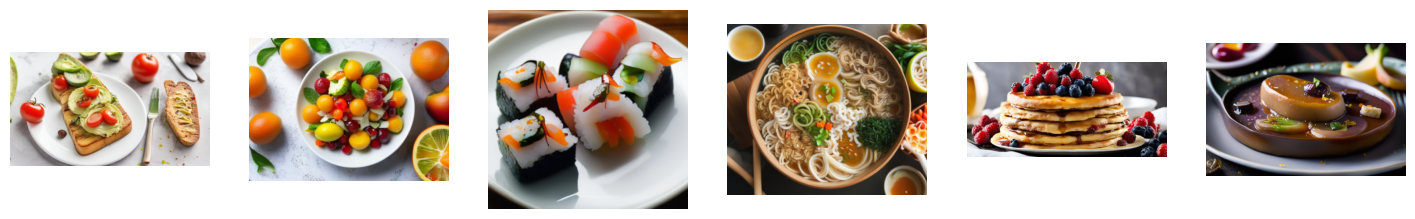

In [ ]:
food_prompts = [
    "Toast with avocado, truffle oil, tomatoes and parma, Italian restaurant in the center of Milan",
    "Juicy fruit salad in a white plate with tangerines, mangoes, lychees and cherry.",
    "Sushi, artfully arranged, glistening with fresh fish and colorful vegetables.",
    "A steaming bowl of ramen, with rich broth, tender noodles, and a symphony of toppings, a comforting and flavorful experience.",
    "A towering stack of fluffy pancakes, drizzled with maple syrup and a mountain of fresh berries, a sweet and comforting indulgence.",
    "An elegant dish of foie gras, seared to perfection, served with a sweet and savory fig jam and a sprinkle of toasted almonds."
]



# параметры для каждой картинки
params = [
    {"guidance_scale": 8.0, "negative_prompt": "dark, dimly lit, mundane lighting", "height": 768, "width": 1344},
    {"guidance_scale": 6.5, "negative_prompt": "flat, uninspired, dull colors", "height": 640, "width": 896},
    {"guidance_scale": 9.0, "negative_prompt": "cartoonish, unrealistic, brightly colored", "height": 512, "width": 512},
    {"guidance_scale": 7.5, "negative_prompt": "lifeless, unappetizing, poorly presented", "height": 768, "width": 896},
    {"guidance_scale": 10.0, "negative_prompt": "blurry, low resolution, pixelated", "height": 640, "width": 1344},
    {"guidance_scale": 8.5, "negative_prompt": "dull, boring background, uninteresting setting", "height": 512, "width": 768}
]


output_dir = "food"
os.makedirs(output_dir, exist_ok=True)

# генерация
images = []
prompts = []

for idx, (prompt, param) in enumerate(zip(food_prompts, params)):
    generator = torch.Generator('cuda').manual_seed(12363)
    image = pipe(prompt,
                 generator=generator,
                 negative_prompt=param["negative_prompt"],
                 height=param["height"],
                 width=param["width"],
                 guidance_scale=param["guidance_scale"],
                 num_inference_steps=30).images[0]

    resized_image = to_256(image)
    image_path = os.path.join(output_dir, f"food_{idx+1}.png")
    resized_image.save(image_path)

    images.append(resized_image)
    prompts.append(prompt)

# вывести картинки
fig, axs = plt.subplots(1, 6, figsize=(18, 3))
for img, ax in zip(images, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

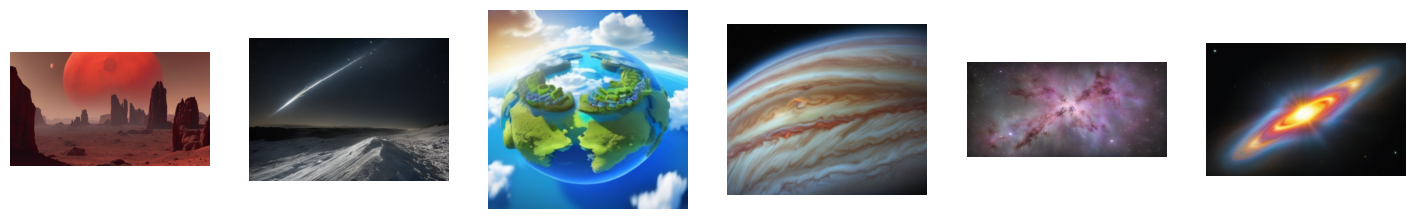

In [ ]:
space_prompts = [
    "A barren, crimson Mars through a telescope, with towering rock formations and a single, red sun.",
    "A majestic comet, close angle, streaking across the night vistas, leaving a shimmering trail of dust and ice.",
    "Realistic сelestial vibrant, blue Earth with floating islands and a sky filled with clouds, cosmic perspective",
    "The panorama from space: A glowing, gas giant Jupiter, with swirling bands of color and a storm raging on its surface.",
    "A glittering, crystalline ethereal nebula of orion, with a dark void, filled with shooting stars.",
    "A quasar, a brilliant beacon of energy, fueled by a supermassive black hole, view from universe."
]



# параметры для каждой картинки
params = [
    {"guidance_scale": 8.0, "negative_prompt": "mundane details, uninteresting perspective", "height": 768, "width": 1344},
    {"guidance_scale": 6.5, "negative_prompt": "cartoonish representation, unrealistic colors", "height": 640, "width": 896},
    {"guidance_scale": 11.0, "negative_prompt": "dull, flat lighting, lack of cosmic grandeur", "height": 512, "width": 512},
    {"guidance_scale": 7.5, "negative_prompt": "lack of mystery, overly bright surroundings", "height": 768, "width": 896},
    {"guidance_scale": 5.5, "negative_prompt": "typical space scene, lack of depth", "height": 640, "width": 1344},
    {"guidance_scale": 10.0, "negative_prompt": "lack of awe, unrealistic environment", "height": 512, "width": 768}
]


output_dir = "space"
os.makedirs(output_dir, exist_ok=True)

# генерация
images = []
prompts = []

for idx, (prompt, param) in enumerate(zip(space_prompts, params)):
    generator = torch.Generator('cuda').manual_seed(12363)
    image = pipe(prompt,
                 generator=generator,
                 negative_prompt=param["negative_prompt"],
                 height=param["height"],
                 width=param["width"],
                 guidance_scale=param["guidance_scale"],
                 num_inference_steps=30).images[0]

    resized_image = to_256(image)
    image_path = os.path.join(output_dir, f"space_{idx+1}.png")
    resized_image.save(image_path)

    images.append(resized_image)
    prompts.append(prompt)

# вывести картинки
fig, axs = plt.subplots(1, 6, figsize=(18, 3))
for img, ax in zip(images, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

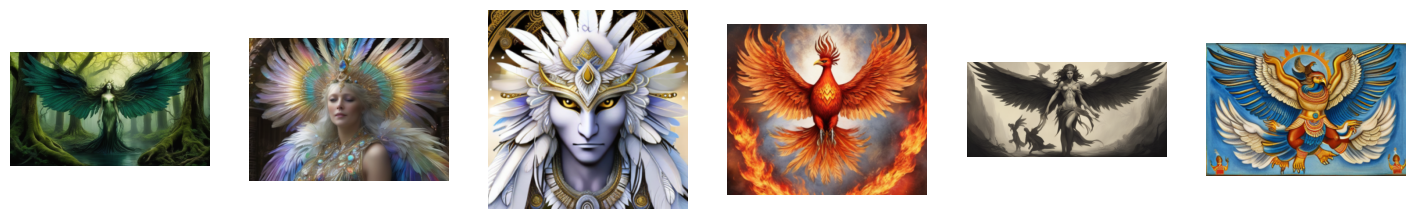

In [ ]:
birds_prompts = [
    "The siren, with wings spanning the breadth of the forest, sings a haunting lament amidst the ancient trees.",
    "The alkonost, adorned with iridescent plumage that shimmers like a thousand rainbows, brings joy and hope to all who hear her song.",
    "The gamayun, a wise and ancient being, with feathers white as snow and golden eyes that pierce the veil of time, foretells the future.",
    "The firebird, with сoat ablaze in fiery hues guards the secret of eternal youth.",
    "The harpy, with a woman's face and the body of a bird, snatches children and carries them away to her shadowy lair.",
    "Garuda, a colossal eagle with a golden beak, carries Vishnu on his back, soaring through the heavens."
]


# параметры для каждой картинки
params = [
    {"guidance_scale": 9.0, "negative_prompt": "mundane background, boring pose", "height": 768, "width": 1344},
    {"guidance_scale": 7.0, "negative_prompt": "cartoonish appearance, unrealistic colors", "height": 640, "width": 896},
    {"guidance_scale": 12.0, "negative_prompt": "dull, flat lighting, unnatural posture", "height": 512, "width": 512},
    {"guidance_scale": 8.5, "negative_prompt": "lack of mystery, overly bright surroundings", "height": 768, "width": 896},
    {"guidance_scale": 6.0, "negative_prompt": "typical bird behavior, mundane setting", "height": 640, "width": 1344},
    {"guidance_scale": 11.0, "negative_prompt": "lack of intrigue, unrealistic environment", "height": 512, "width": 768}
]


output_dir = "birds"
os.makedirs(output_dir, exist_ok=True)

# генерация
images = []
prompts = []

for idx, (prompt, param) in enumerate(zip(birds_prompts, params)):
    generator = torch.Generator('cuda').manual_seed(12363)
    image = pipe(prompt,
                 generator=generator,
                 negative_prompt=param["negative_prompt"],
                 height=param["height"],
                 width=param["width"],
                 guidance_scale=param["guidance_scale"],
                 num_inference_steps=30).images[0]

    resized_image = to_256(image)
    image_path = os.path.join(output_dir, f"bird_{idx+1}.png")
    resized_image.save(image_path)

    images.append(resized_image)
    prompts.append(prompt)

# вывести картинки
fig, axs = plt.subplots(1, 6, figsize=(18, 3))
for img, ax in zip(images, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

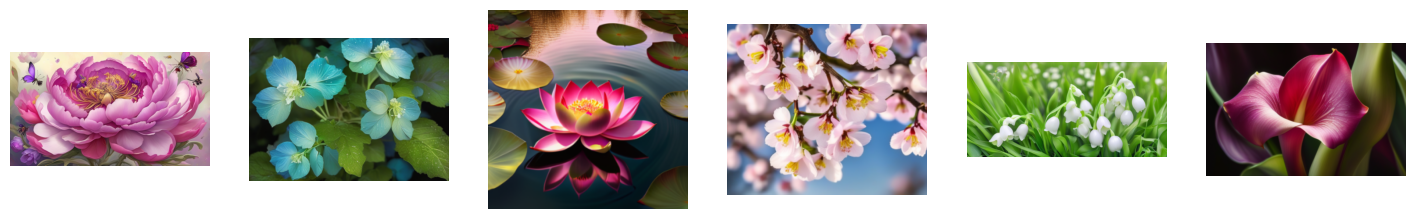

In [ ]:
flowers_prompts = [
    "An alien peony with amethyst and ruby petals with dreamlike insects flying around.",
    "A cluster of bioluminescent hydrangeas, their sepals pulsating with soft, ethereal light, casting a gleam upon the fairy landscape.",
    "A hyperrealistic lotus, its leaves unfurling in a radiant spiral of gold and crimson, floating serenely upon a otherworldly lake.",
    "Cherry blossoms, their florets cascading down a graceful branch, shimmering with a delicate, celestial silent glow.",
    "A very lush lily of the valley with chiseled white almost transparent bells grows in the grass",
    "A calla blending from soft ivory to vibrant crimson, each vein luminous with nacreous incandescence."
]

# параметры для каждой картинки
params = [
    {"guidance_scale": 7.5, "negative_prompt": "dark screen", "height": 768, "width": 1344},
    {"guidance_scale": 5.0, "negative_prompt": "poorly detailed, low quality", "height": 640, "width": 896},
    {"guidance_scale": 10.0, "negative_prompt": "cartoonishness", "height": 512, "width": 512},
    {"guidance_scale": 8.0, "negative_prompt": "dull, lifeless, dark screen", "height": 768, "width": 896},
    {"guidance_scale": 6.5, "negative_prompt": "dark, shadowy", "height": 640, "width": 1344},
    {"guidance_scale": 9.0, "negative_prompt": "noisy, grainy, boring background, typical laptop shape", "height": 512, "width": 768}
]

output_dir = "flowers"
os.makedirs(output_dir, exist_ok=True)

# генерация
images = []
prompts = []

for idx, (prompt, param) in enumerate(zip(flowers_prompts, params)):
    generator = torch.Generator('cuda').manual_seed(12363)
    image = pipe(prompt,
                 generator=generator,
                 negative_prompt=param["negative_prompt"],
                 height=param["height"],
                 width=param["width"],
                 guidance_scale=param["guidance_scale"],
                 num_inference_steps=30).images[0]

    resized_image = to_256(image)
    image_path = os.path.join(output_dir, f"flower_{idx+1}.png")
    resized_image.save(image_path)

    images.append(resized_image)
    prompts.append(prompt)

# вывести картинки
fig, axs = plt.subplots(1, 6, figsize=(18, 3))
for img, ax in zip(images, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

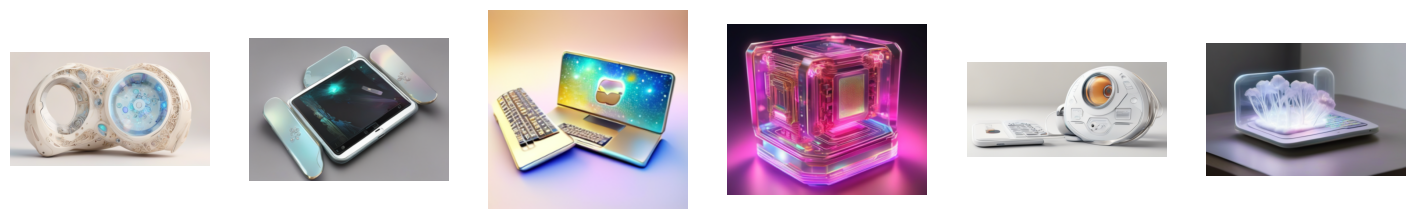

In [ ]:
gadgets_prompts = [
    "A minimalist, delicate, refined, and intricately detailed, curiously strange, whimsical advanced device with large touch screen.",
    "A sophisticated tablet, it shows a video game, silvery and iridescent colors, blending light Japanese style elements.",
    "An elegant shimmering computer with a Mac OS interface from the distant future",
    "A charming, luminous, cutting-edge holographic gadget with a quantum processor and pink frosted.",
    "A state-of-the-art electronic сybernetic marvel for Internet surfing from the year 2300, embracing a Scandinavian aesthetic, defined by clean lines, soft focus.",
    "An innovative laptop, emitting soft, ethereal light, a sense of whimsical wonder, made from a light gray aerogel."
]
# параметры для каждой картинки
params = [
    {"guidance_scale": 7.5, "negative_prompt": "dark screen", "height": 768, "width": 1344},
    {"guidance_scale": 5.0, "negative_prompt": "poorly detailed, low quality", "height": 640, "width": 896},
    {"guidance_scale": 10.0, "negative_prompt": "thick form, black screen", "height": 512, "width": 512},
    {"guidance_scale": 8.0, "negative_prompt": "dull, lifeless", "height": 768, "width": 896},
    {"guidance_scale": 6.5, "negative_prompt": "dark, shadowy", "height": 640, "width": 1344},
    {"guidance_scale": 9.0, "negative_prompt": "noisy, grainy, boring background, typical laptop shape", "height": 512, "width": 768}
]

output_dir = "gadgets"
os.makedirs(output_dir, exist_ok=True)

# генерация
images = []
prompts = []

for idx, (prompt, param) in enumerate(zip(gadgets_prompts, params)):
    generator = torch.Generator('cuda').manual_seed(12363)
    image = pipe(prompt,
                 generator=generator,
                 negative_prompt=param["negative_prompt"],
                 height=param["height"],
                 width=param["width"],
                 guidance_scale=param["guidance_scale"],
                 num_inference_steps=30).images[0]

    resized_image = to_256(image)
    image_path = os.path.join(output_dir, f"gadget_{idx+1}.png")
    resized_image.save(image_path)

    images.append(resized_image)
    prompts.append(prompt)

# вывести картинки
fig, axs = plt.subplots(1, 6, figsize=(18, 3))
for img, ax in zip(images, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

### 2) Извлечение эмбеддингов с помощью CLIP

In [ ]:
from transformers import CLIPProcessor, CLIPModel

In [ ]:
output_dirs = ["gadgets", "food", "space", "birds", "flowers"]

images = []
image_paths_list = []

for output_dir in output_dirs:
    image_paths = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')]
    image_paths_list.append(image_paths)  # Сохраняем список путей для каждой категории
    for image_path in image_paths:
        image = Image.open(image_path)
        images.append(np.array(image))


In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [ ]:
def get_image_embeddings(images):
    inputs = clip_processor(images=images, return_tensors="pt", padding=True)
    outputs = clip_model.get_image_features(**inputs)
    return outputs.detach().numpy()

image_embeddings = get_image_embeddings(images)

In [ ]:
image_embeddings

array([[ 0.03485507,  0.7842609 ,  0.13594759, ...,  0.14658016,
        -0.02627939, -0.3494244 ],
       [-0.19764367,  0.45673817,  0.00490625, ...,  0.31838   ,
        -0.03650503,  0.01297888],
       [-0.21527126,  0.48540044, -0.04610612, ...,  0.6203999 ,
        -0.2471788 , -0.599796  ],
       ...,
       [-0.34815472,  0.03559298, -0.13418394, ...,  0.42804426,
        -0.13404043, -0.5394226 ],
       [ 0.18978426,  0.57780194, -0.22316492, ...,  0.64103806,
         0.08840615,  0.07868659],
       [ 0.40514892,  0.20558804,  0.2928571 , ...,  0.53394306,
         0.0505477 ,  0.10401191]], dtype=float32)

### 3) Кластеризация изображений с помощью KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
predicted_labels = kmeans.fit_predict(image_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
true_labels = np.repeat(np.arange(len(output_dirs)), 6)
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI) Score: {ari_score}")

Adjusted Rand Index (ARI) Score: 1.0


In [ ]:
def print_cluster_assignments(labels, n_clusters):
    for cluster in range(n_clusters):
        cluster_indices = [idx for idx, label in enumerate(labels) if label == cluster]
        print(f"Кластер {cluster + 1} содержит картинки: {cluster_indices}")

print_cluster_assignments(predicted_labels, n_clusters)

Кластер 1 содержит картинки: [12, 13, 14, 15, 16, 17]
Кластер 2 содержит картинки: [24, 25, 26, 27, 28, 29]
Кластер 3 содержит картинки: [6, 7, 8, 9, 10, 11]
Кластер 4 содержит картинки: [0, 1, 2, 3, 4, 5]
Кластер 5 содержит картинки: [18, 19, 20, 21, 22, 23]


In [ ]:
# модель всё угадала правильно

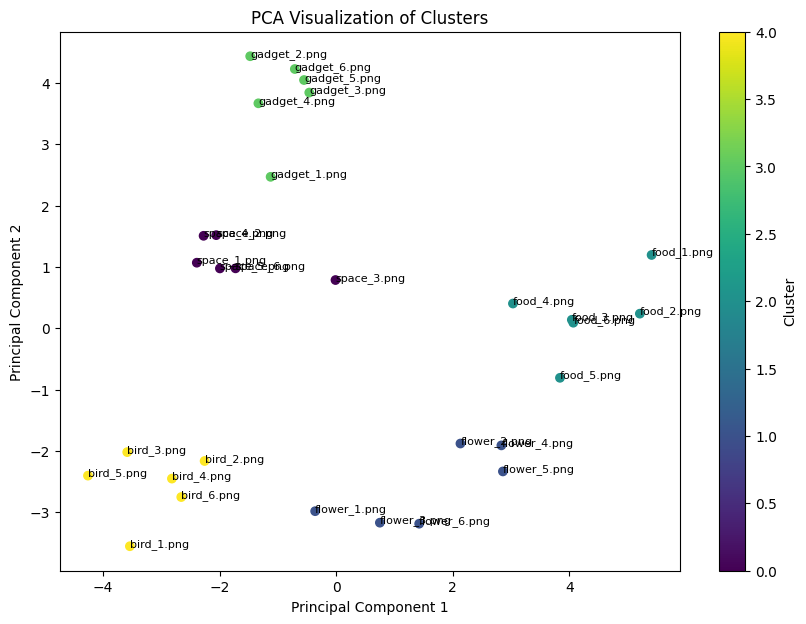

In [ ]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(image_embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=predicted_labels, cmap='viridis')  # Цвет точек соответствует предсказанным меткам кластеров
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

for i, image_paths in enumerate(image_paths_list):
    for idx, image_path in enumerate(image_paths):
        plt.annotate(os.path.basename(image_path), (reduced_features[i * 6 + idx, 0], reduced_features[i * 6 + idx, 1]), fontsize=8)

plt.show()

In [ ]:
# кластеры довольно далеко друг от друга
# заметна логика: птицы визуально ближе к цветам, чем к гаджетам

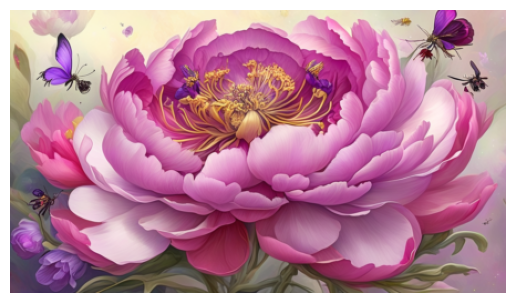

In [ ]:
# цветок 1 больше похож на птицу, чем другие цветы, и правда
image_path = "flowers/flower_1.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

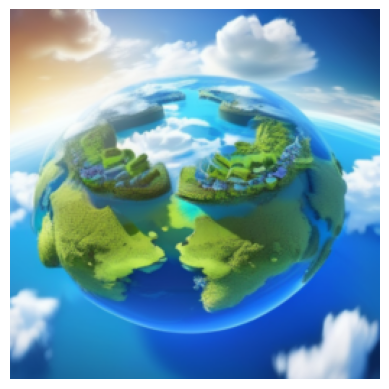

In [ ]:
# космос 3 немного похож на еду, есть немного
image_path = "space/space_3.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

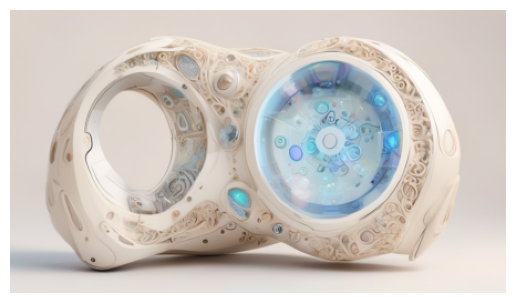

In [ ]:
# гаджет 1 похож на космос больше, чем другие гаджеты. и правда
image_path = "/content/gadgets/gadget_1.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

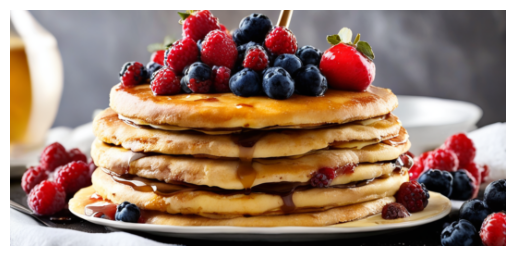

In [ ]:
# цветок 1 больше похож на птицу, чем другие цветы, и правда
image_path = "/content/food/food_5.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

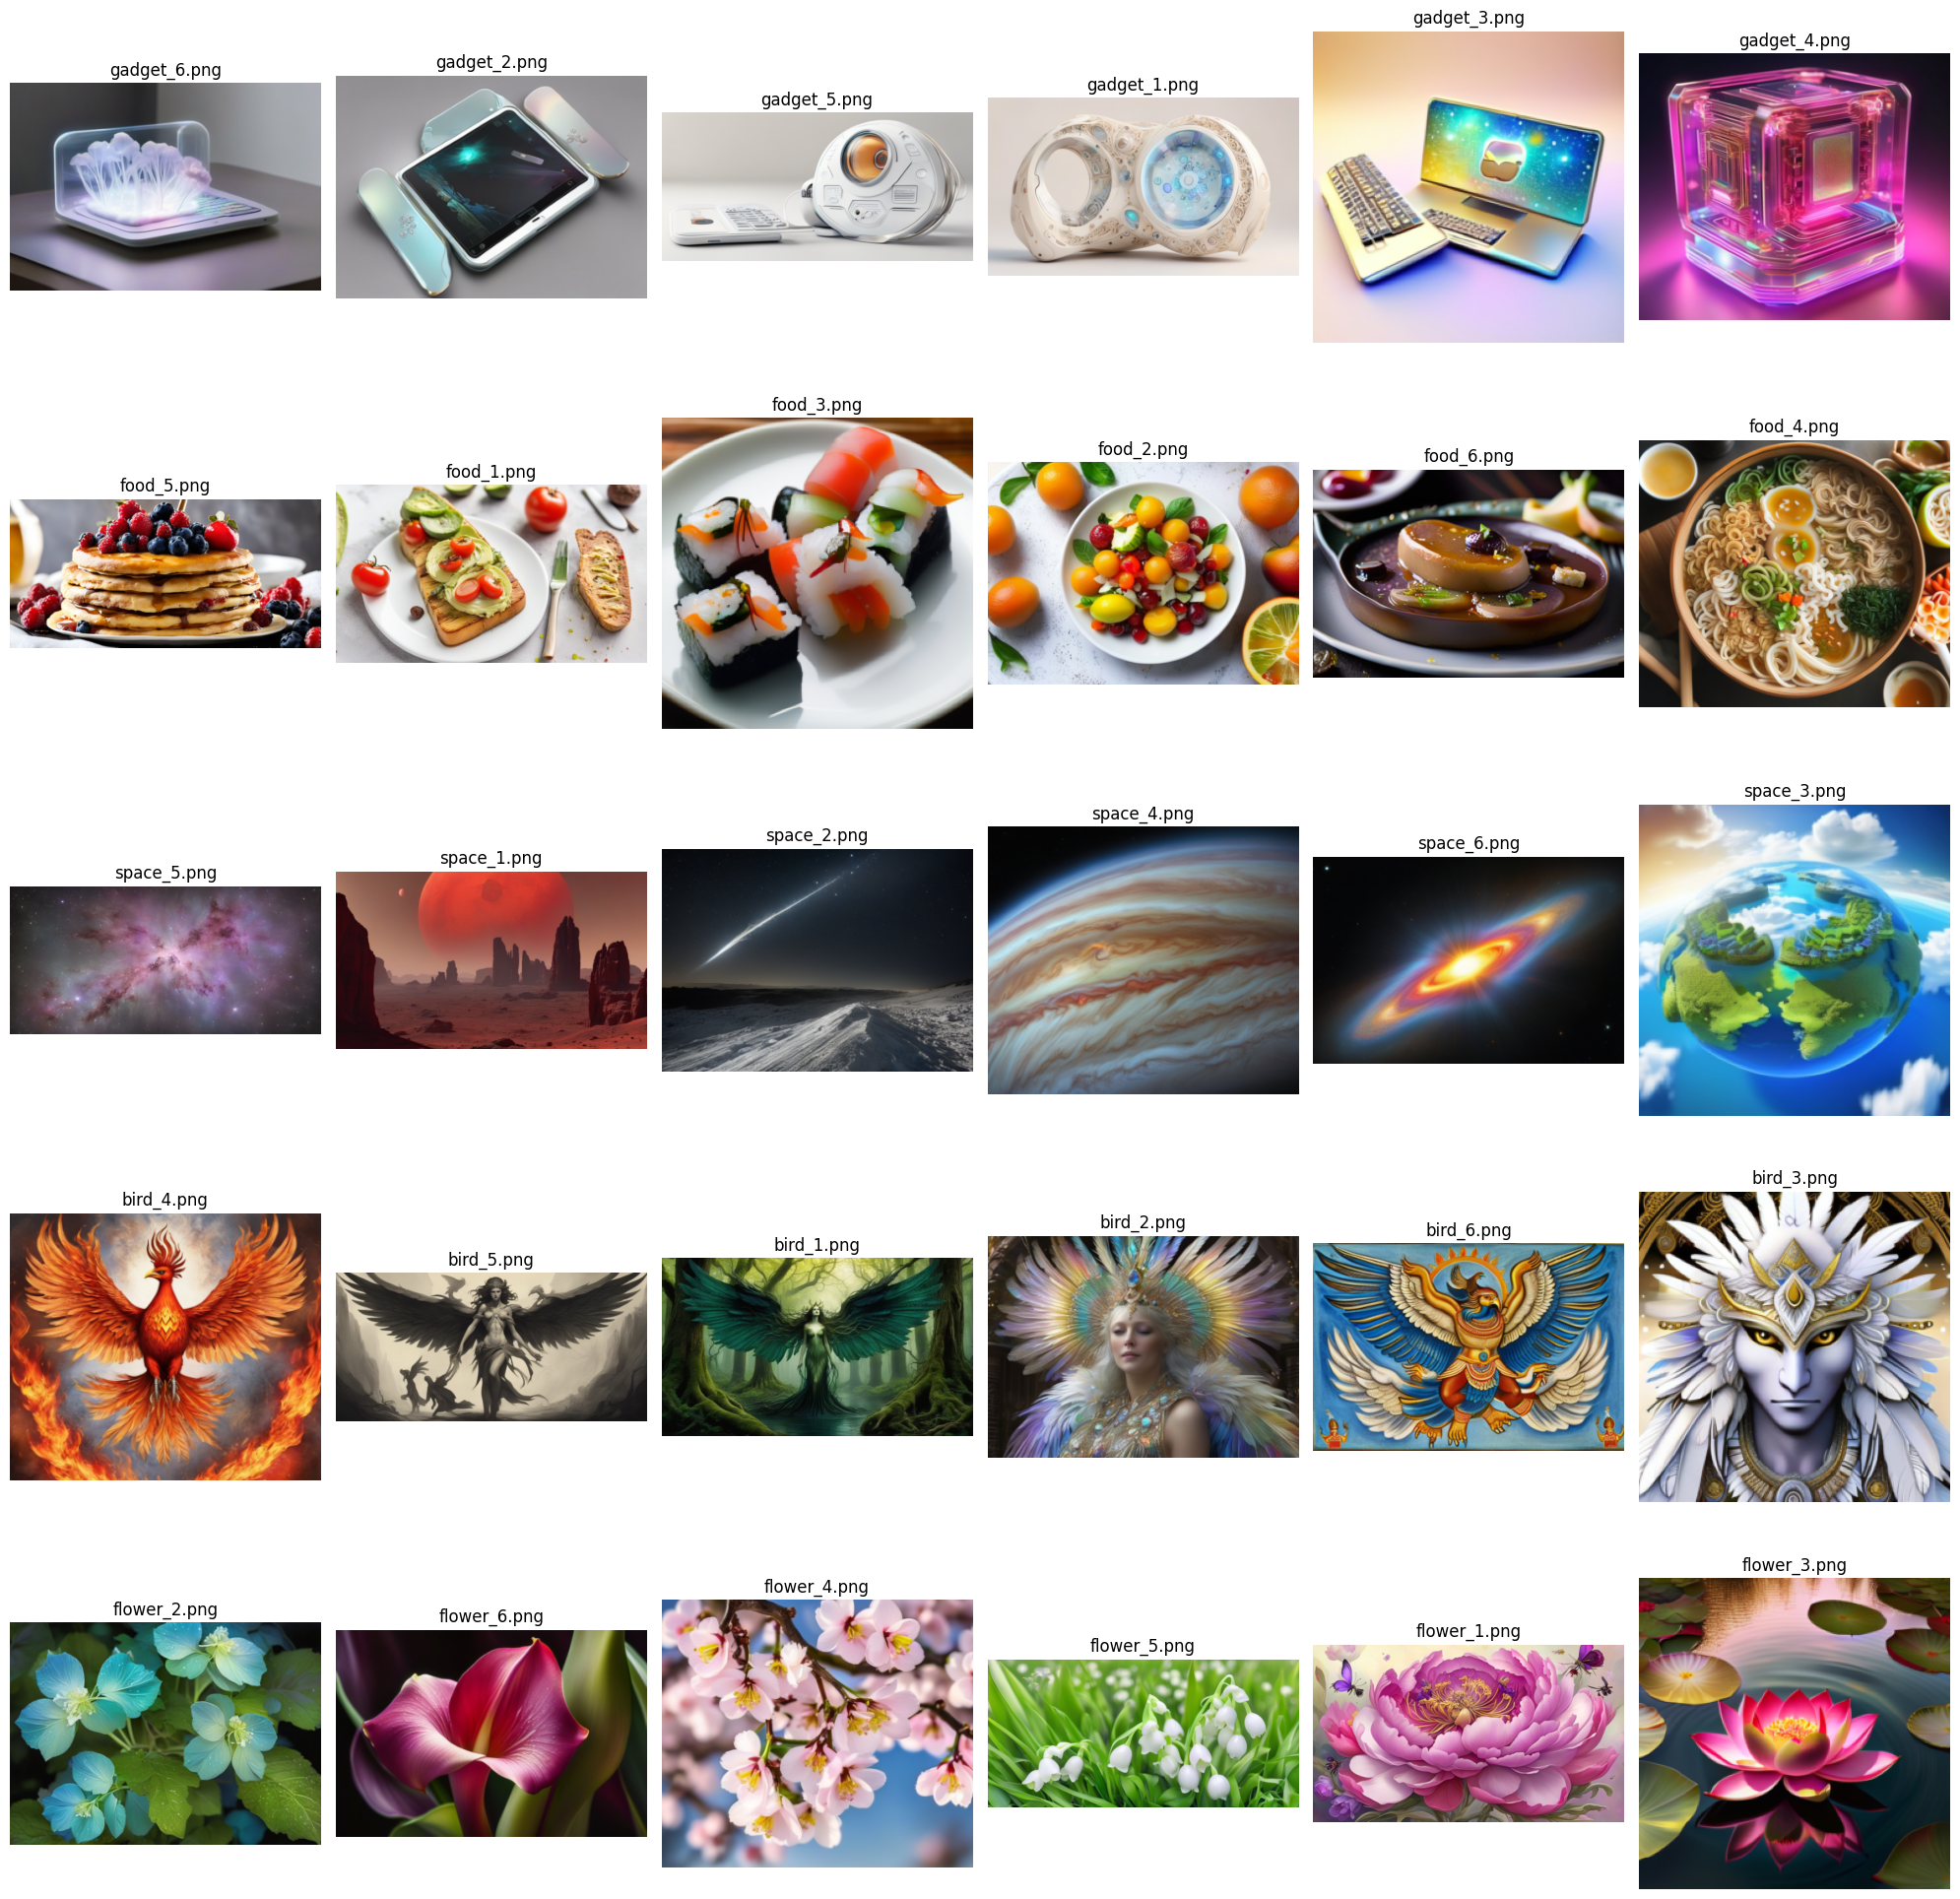

In [ ]:
output_dirs = ["gadgets", "food", "space", "birds", "flowers"]

def show_images_with_filenames(output_dirs):
    fig, axs = plt.subplots(len(output_dirs), 6, figsize=(20, 20))

    for i, output_dir in enumerate(output_dirs):
        image_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(output_dir, image_file)
            image = Image.open(image_path)
            axs[i, j].imshow(image)
            axs[i, j].axis('off')
            axs[i, j].set_title(image_file)
    plt.tight_layout()
    plt.show()

show_images_with_filenames(output_dirs)
